![ROSES 2021 Header](header.png)

Notebook Authors: Chet Goerzen & Dr. Adebayo Oluwaseun Ojo

In [1]:
import sys
import time
import obspy
import pyasdf # For accessing the data format used by NoiesPy
import os, glob
import numpy as np
import pandas as pd
from obspy import UTCDateTime
import matplotlib.pyplot as plt
import scipy # Mainly used for interpolation
import pycwt # We will need to do this to perform the wavelet analysis for dispersion curve measurement
from obspy.clients.fdsn import Client

client = Client("IRIS") # Initialize Client to download data from IRIS


import noise_module # Import code from NoisePy

# Disclaimer:

While derived from previous examples, the code in this notebook has not been extensively tested. If you would like to use this code for your own research, it would be wise to critically analyze the code and perform your own tests.

# Extraction of Green's Functions from Ambient Noise

This section is based on the example provided with the NoisePy code (https://github.com/chengxinjiang/NoisePy/blob/master/Jupyter_notebook/download_toASDF_cross_correlation.ipynb). The original notebook was produced by Dr. Chengxin Jiang

The following cell downloads data from two stations of the Transportable Array and does some pre-processing. The trend and mean of the data are removed, gaps are filled with zeros, the sampling frequency is downsampled from 40 Hz to 3 Hz, and the instrument response is removed. In this case I've already downloaded the data, but one my use this to download data of your own. In this case only 5 days of data is used, which is a very short period for ambient noise tomography. In order to get good results one may need many months or even years of data. NoisePy offers scripts to either download data or re-organize an existing dataset on your local machine.

In [2]:
# Modified from NoisePy
# samp_freq = 3                      # targeted sampling rate at X samples per seconds 
# rm_resp   = 'inv'                  # select 'no' to not remove response and use 'inv','spectrum','RESP', or 'polozeros' to remove response
# respdir   = './'                   # directory where resp files are located (required if rm_resp is neither 'no' nor 'inv')
# freqmin   = 0.25                   # pre filtering frequency bandwidth
# freqmax   = 1                      # note this cannot exceed Nquist freq                         

# chan = ['BHZ','BHZ']               # channel for each station
# net  = ['TA','TA']                 # network for each station 
# sta  = ['K62A','K63A']             # station (using a station list is way either compared to specifying stations one by one)
# start_date = ["2014_01_01_0_0_0"]  # start date of download
# end_date   = ["2014_01_05_0_0_0"]  # end date of download
# inc_hours  = 24                    # length of data for each request (in hour)
# nsta       = len(sta)

# # save prepro parameters into a dict
# prepro_para = {'rm_resp':rm_resp,'respdir':respdir,'freqmin':freqmin,'freqmax':freqmax,'samp_freq':samp_freq,'start_date':\
#     start_date,'end_date':end_date,'inc_hours':inc_hours}

# # convert time info to UTC format
# starttime = obspy.UTCDateTime(start_date[0])       
# endtime   = obspy.UTCDateTime(end_date[0])
# date_info = {'starttime':starttime,'endtime':endtime}

# # write into ASDF file: using start and end time as file name
# ff=os.path.join('roses_test.h5')
# with pyasdf.ASDFDataSet(ff,mpi=False,compression="gzip-3",mode='w') as ds:

#     # loop through each station
#     for ista in range(nsta):

#         # get inventory for each station
#         try:
#             sta_inv = client.get_stations(network=net[ista],station=sta[ista],\
#                 location='*',starttime=starttime,endtime=endtime,level="response")
#         except Exception as e:
#             print(e);continue

#         # add the inventory into ASDF        
#         try:
#             ds.add_stationxml(sta_inv) 
#         except Exception: 
#             pass   

#         try:
#             # get data
#             tr = client.get_waveforms(network=net[ista],station=sta[ista],\
#                 channel=chan[ista],location='*',starttime=starttime,endtime=endtime)
#         except Exception as e:
#             print(e,'for',sta[ista]);continue
            
#         # preprocess to clean data  
#         print('working on station '+sta[ista])
#         tr = noise_module.preprocess_raw(tr,sta_inv,prepro_para,date_info)

#         if len(tr):
#             new_tags = '{0:s}_00'.format(chan[ista].lower())
#             ds.add_waveforms(tr,tag=new_tags)

In this next cell, all the parameters needed to set up the cross-correlation are defined. In this case, the recorded time series will be broken into thirty minute segments. The step size is 15 minutes, leading to an overlap of 50%. In this case, both frequency and time domain normalization is used. The time domain normalization used in this example is one-bit normalization. This means that only the sign of the time series recorded at each station is saved. This is done to reduce the effect of transient signals such as earthquakes. A running mean average is applied to the amplitude spectrum of the signal, with a window length of 100 samples. This smooths the frequency content of the signal. The data will also be bandpass filtered between 0.25 Hz and 1 Hz, as this is the frequency range we are interested in for this example. The maximum time lag to be saved is 200 seconds, meaning that the cross-correlation will be saved from -200 to 200 seconds. Any signals greater than 10 times the standard deviation of the normalized and filtered signal will be removed.

In [3]:
# Modified from NoisePy
sfile = glob.glob('data/ROSES_CCF.h5')      # find hdf5 files

# Set up the parameters
# --------------------------------------------------------------------------------------------------------------- #
# parameters of fft_cc
cc_len    = 1800         # window length (sec) to cut daily data into small segments
step      = 900          # overlapping (sec) between the sliding window
smooth_N  = 100          # number of points to be smoothed for running-mean average (time-domain)
inc_hours = 24           # basic length (hour) of the continous noise data        

freq_norm   = 'rma'      # rma-> running mean average for frequency-domain normalization
time_norm   = 'one_bit'  # no-> no time-domain normalization; other options 'rma' for running-mean and 'one_bit'
cc_method   = 'xcorr'    # xcorr-> pure cross correlation; other option is 'decon'
substack       = False   # sub-stack daily cross-correlation or not, doesn't matter for this example
substack_len   = cc_len  # how long to stack over: need to be multiples of cc_len,
                         # changing this will not affect this example
    
smoothspect_N  = 100     # number of points to be smoothed for running-mean average (freq-domain)
freqmin   = 0.25         # pre filtering frequency bandwidth
freqmax   = 1            # note this cannot exceed Nquist freq 

# cross-correlation parameters
maxlag       = 200       # time lag (sec) for the cross correlation functions
max_over_std = 10        # amplitude threshold to remove segments of spurious phases
# --------------------------------------------------------------------------------------------------------------- #

Now we'll load in the data for both the receiver and source

In [4]:
# Modified from NoisePy
# read source and some meta info
with pyasdf.ASDFDataSet(sfile[0],mode='r') as ds:
    
    # station list
    sta_list = ds.waveforms.list()
    print('source of %s and receiver %s'%(sta_list[0],sta_list[1]))
    
    # channels for each station
    all_tags = ds.waveforms[sta_list[0]].get_waveform_tags()
    
    # get the source trace
    tr_source = ds.waveforms[sta_list[0]][all_tags[0]]
    
    # get the source trace
    tr_receiver = ds.waveforms[sta_list[1]][all_tags[0]]
    
    # read inventory
    inv1 = ds.waveforms[sta_list[1]]['StationXML']
    
    # read receiver station info from inventory
    rsta,rnet,rlon,rlat,elv,loc = noise_module.sta_info_from_inv(inv1)
    
    # Get the sampling information
    dt = tr_source[0].stats.delta
    samp_freq = 1 /dt
    
    # read inventory
    inv1 = ds.waveforms[sta_list[0]]['StationXML']
    
    # read source station info from inventory
    ssta,snet,slon,slat,elv,loc = noise_module.sta_info_from_inv(inv1)
    
# group parameters into a dict
fc_para={'samp_freq':samp_freq,'dt':dt,'cc_len':cc_len,'step':step,'freq_norm':freq_norm,'time_norm':time_norm,\
    'cc_method':cc_method,'maxlag':maxlag,'max_over_std':max_over_std,'inc_hours':inc_hours,'smooth_N':smooth_N,\
    'freqmin':freqmin,'freqmax':freqmax,'smoothspect_N':smoothspect_N,'substack':substack,\
    'substack_len':substack_len}

# Calculate distance between source and receiver
dist,_,_ = obspy.geodetics.base.gps2dist_azimuth(slat,slon,rlat,rlon)

# cut source traces into small segments and make statistics
trace_stdS,dataS_t,dataS = noise_module.cut_trace_make_stat(fc_para,tr_source)

# do fft to freq-domain
source_white = noise_module.noise_processing(fc_para,dataS)
source_white = np.conjugate(source_white) # Take the conjugate, so that the source spectrum is consistent with
                                          # the receiver function

# cut receiver traces into small segments and make statistics
trace_stdR,dataR_t,dataR = noise_module.cut_trace_make_stat(fc_para,tr_receiver)

# do fft to freq-domain
receiver_white = noise_module.noise_processing(fc_para,dataR)

# num of frequency data
Nfft = source_white.shape[1];Nfft2 = Nfft//2

# find the right index of good signals for source and receiver
sou_ind = np.where((trace_stdS<max_over_std)&(trace_stdS>0)&(np.isnan(trace_stdS)==0))[0]
rec_ind = np.where((trace_stdR<max_over_std)&(trace_stdR>0)&(np.isnan(trace_stdR)==0))[0]

source of TA.K62A and receiver TA.K63A


The below plot shows the pre-processed time series. Note that the frequency normalization has changed the amplitude of the signal. Without frequency normalization the only values would be 1 or -1, due to the one-bit normalization.

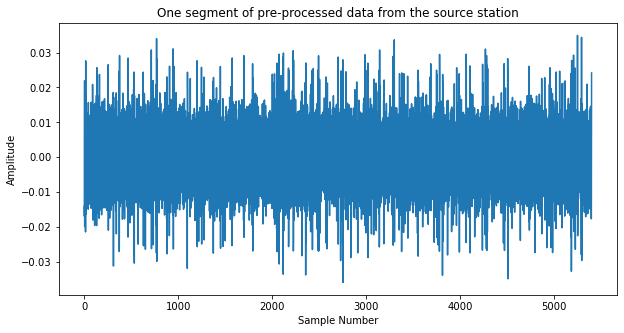

In [5]:
# Due to the processing scheme employed by NoisePy, the pre-processed data is stored in the frequency domain.
# In order to see the time domain the inverse fourier transform must be applied
time_series = np.fft.ifft(source_white[1])

# Some small complex values are left after the inverse fourier transform. Using np.real() will discard them.
real_time_series = np.real(time_series)

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(real_time_series)
ax.set_title("One segment of pre-processed data from the source station")
ax.set_xlabel("Sample Number")
ax.set_ylabel("Amplitude")
plt.show()

Below is the amplitude spectrum. Note that it has been smoothed with a smoothing window of 100 samples.

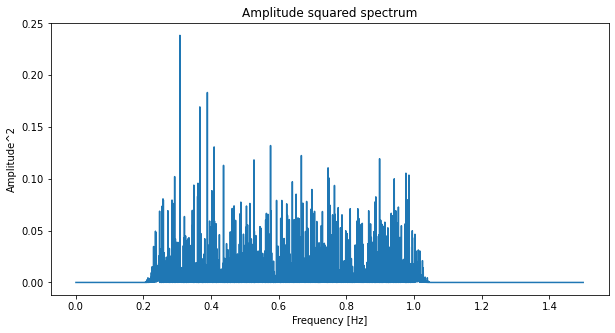

In [6]:
fft_stack = np.mean(source_white, axis=0) # Stack each spectrum. This is essentially Welch's method
freqs = np.fft.rfftfreq(len(fft_stack)-1, dt) # Get the correct frequencies
freqs = freqs[1:] # Throw out the DC component

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(freqs, np.abs(fft_stack[1:Nfft2]) ** 2) # Plot the amplitude squared spectrum
ax.set_title("Amplitude squared spectrum")
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("Amplitude^2")
plt.show()

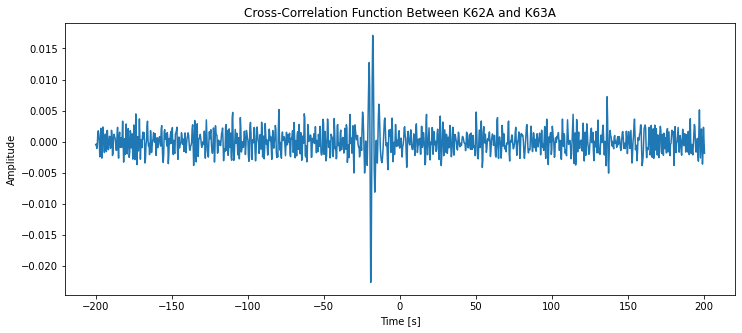

In [7]:
# Modified from NoisePy

# find the segments of good data for both source and receiver
bb=np.intersect1d(sou_ind,rec_ind)

# do cross correlation
tdata,t_corr,n_corr = noise_module.correlate(source_white[bb,:Nfft2],receiver_white[bb,:Nfft2],fc_para,Nfft,dataS_t)

# plot the waveform
tvec = np.linspace(-maxlag,maxlag+dt,len(tdata))
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(tvec,tdata)
ax.set_xlabel("Time [s]")
ax.set_ylabel("Amplitude")
ax.set_title('Cross-Correlation Function Between %s and %s'%(ssta,rsta))
plt.show()

Notice how asymmetrical the cross-correlation function is!!! It is also pretty noisy. What do you think we could do to improve the cross-correlation function?

# Measuring Dispersion Curves From Cross-Correlation Functions

The following example makes use of code adapted from the dispersion analysis code in NoisePy (https://github.com/chengxinjiang/NoisePy/tree/master/src/application_modules). A frequency-time image is produced using the wavelet transform, and then converted into a velocity-period image. The group velocity curve is then selected from the ridge on the velocity-period image. In this example, we will take the mean of both the positive and negative lags of the cross-correlation function. This is known as the symmetrical component of the cross-correlation function. The method outlined in Jiang & Denolle, 2020 is used to produce the period-velocity image and measure the dispersion curve.

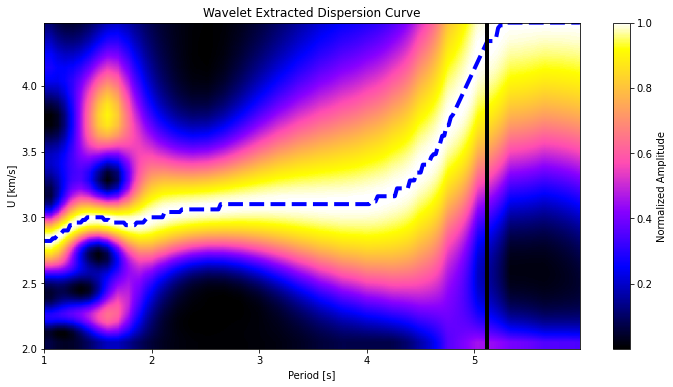

In [8]:
# Modified from NoisePy

# Set up the parameters
# --------------------------------------------------------------------------------------------------------------- #
# targeted freq bands for dispersion analysis
pmin = 1
pmax = 6
fmin = 1 / pmax
fmax = 1 / pmin
per  = np.arange(pmin,pmax,0.02)

# set time window for disperion analysis
vmin = 2.0
vmax = 4.5
vel  = np.arange(vmin,vmax,0.02)

# basic parameters for wavelet transform, these generally don't need to be changed
dj=1/12
s0=-1
J=-1
wvn='morlet'
# --------------------------------------------------------------------------------------------------------------- #

# Calculate the symmetrical waveform
npts = int(1/dt) * 2 * maxlag + 1
indx = npts // 2
data = 0.5 * tdata[indx:] + 0.5 * np.flip(tdata[:indx+1], axis=0)
# data = tdata[indx:]

dist_km = dist / 1000

pt1 = int(dist_km/vmax/dt)
pt2 = int(dist_km/vmin/dt)
indx = np.arange(pt1, pt2)
tvec = indx * dt
data = data[indx]

# wavelet transformation
cwt, sj, freq, coi, _, _ = pycwt.cwt(data, dt, dj, s0, J, wvn)

# do filtering here
if (fmax > np.max(freq)) | (fmax <= fmin):
    raise ValueError('Abort: frequency out of limits!')
freq_ind = np.where((freq >= fmin) & (freq <= fmax))[0]
cwt = cwt[freq_ind]
freq = freq[freq_ind]

# use amplitude of the cwt
period = 1 / freq
rcwt = np.abs(cwt) ** 2

# interpolation to grids of freq-vel
fc = scipy.interpolate.interp2d(dist_km / tvec, period, rcwt)
rcwt_new = fc(vel, per)

# do normalization for each frequency
for ii in range(len(per)):
    rcwt_new[ii] /= np.max(rcwt_new[ii])
    
nper, gv = noise_module.extract_dispersion(rcwt_new, per, vel) # Measure the dispersion curve from the 
                                                               # velocity-period map

# Find the first instance where the wavelength is greater than 1/3 of the inter-station distance
lmbda = gv * nper
bad_idx = np.where(lmbda > dist_km / 3)[0]

fig, ax = plt.subplots(figsize=(12,6))
im = ax.imshow(np.transpose(rcwt_new),cmap='gnuplot2',extent=[per[0],per[-1],vel[0],vel[-1]],
           aspect='auto',origin='lower')

ax.plot(nper,gv,'b--', linewidth=4.0)
ax.plot([nper[bad_idx[0]], nper[bad_idx[0]]], [vel[0], vel[-1]],
        "-", color="black", linewidth=4.0) # Plot the first period where lambda is greater
                                           # than the distance divided by 3
ax.set_xlabel('Period [s]')
ax.set_ylabel('U [km/s]')
ax.set_title("Wavelet Extracted Dispersion Curve")
cbar = plt.colorbar(im)
cbar.set_label("Normalized Amplitude")
plt.show()

This isn't the cleanest dispersion curve, but one can see that there is an obvious moveout with period. Now that you know how the process works, try making a dispersion curve between two stations of your choosing!

# Making a 2-D map of surface wave velocities

There are two further steps to go from a set of dispersion curves to a 3-D map of the subsurface. The first step is to make a 2-D period map. When we measure a dispersion curve between two stations. We are observing the effects of the subsurface over the entire distance along these two stations. The purpose of the 2-D period map is to determine where along this path the variations in velocity occur. Here I'll use pysismo, produced by Dr. Bruno Gotourbes as the framework for developing these 2-D period maps. I'll go through the tomography workflow step by step, although I have also included a wrapper function called `invert4model` in rosesutils that can be used to do the same thing but more concisely.

In [9]:
import itertools as it
import time
import pygmt
import xarray as xr
from matplotlib.lines import Line2D
%load_ext autoreload
%autoreload 2

import pysismo
from pysismo import psutils
from pysismo import rosesutils
from pysismo.pstomo import Grid
# Import utilities for ROSES course
# -------------------------------------------- #
from pysismo.rosesutils import invert4model # A function to wrap the inversion
from pysismo.rosesutils import make_paths # Calculates stright raypaths between stations
from pysismo.rosesutils import make_grid # Makes the inversion grid
from pysismo.rosesutils import plot_interpolated # Plots an interpolated model overlain on a geographic basemap
# -------------------------------------------- #

Reading configuration file: ./tomo_Brazil.cnf


While it would be nice to calculate our won dispersion curves and use them for tomography, that would simply just take too long. So instead we'll use an existing dataset. Note that in the data directory there is a folder called `cam`. This folder contains data from Ojo, Ni & Li, 2017, and corresponds to a seismic array deployed near Cameroon. The files are organized by period, and contain group velocity measurements for many inter-station paths at the specified period. The data do not have headers, but the column names are added in the following cell, which should make the data contained in each column clear.

Here we'll load in the data. Files are named based on the period at which they are measured. In order to clean the data a bit, I'll reject any measurements that fall outside 3 times the standard deviation of the original dataset. There may be better ways to do this, but it is a simple way of cleaning the data and works for our purposes.

In [10]:
disp_curves = pd.read_csv("data/cam/10.dat", index_col=None, header=None, delim_whitespace=True)
disp_curves.columns = ["source_name", "receiver_name", "group_velocity", "phase_velocity",
                       "signal2noise_ratio", "source_lon", "source_lat", "receiver_lon", "receiver_lat",
                       "inter-station_distance"]
ori = len(disp_curves)
std_crit = (np.abs(disp_curves.group_velocity - np.mean(disp_curves.group_velocity)) < 3 * np.std(disp_curves.group_velocity))
disp_curves = disp_curves[std_crit]
clean = len(disp_curves)
print(f"{ori - clean} measurements were removed")

4 measurements were removed


Here we will setup the inversion grid. A small buffer of size `tol` is added, to ensure that no raypaths fall outside the grid, which would be bad. A `Grid` object from the pysismo code will be used to handle this task.

In [11]:
# Modified from seismic-noise-tomgraphy

# Setup the inversion grid
# --------------------------------------------------------------------------------------------------------------- #
tol = 0.5
lonstep = 0.25
latstep = 0.25

# Get the smallest longitude
min_rcv_lon = np.min(disp_curves["receiver_lon"])
min_src_lon = np.min(disp_curves["source_lon"])
min_lon = np.min([min_rcv_lon, min_src_lon]) - tol

# Get the smallest latitude
min_rcv_lat = np.min(disp_curves["receiver_lat"])
min_src_lat = np.min(disp_curves["source_lat"])
min_lat = np.min([min_rcv_lat, min_src_lat]) - tol

# Get the largest longitude
max_rcv_lon = np.max(disp_curves["receiver_lon"])
max_src_lon = np.max(disp_curves["source_lon"])
max_lon = np.max([max_rcv_lon, max_src_lon])

# Get the largest latitude
max_rcv_lat = np.max(disp_curves["receiver_lat"])
max_src_lat = np.max(disp_curves["source_lat"])
max_lat = np.max([max_rcv_lat, max_src_lat])


nlon = np.ceil((max_lon + tol - min_lon) / lonstep)
nlat = np.ceil((max_lat + tol - min_lat) / latstep)

print(f"Number of nodes in longitude direction: {int(nlon):d}")
print(f"Number of nodes in latitude direction: {int(nlat):d}")

# Create a grid object, from pysismo
grid = Grid(min_lon, lonstep, nlon, min_lat, latstep, nlat)
# --------------------------------------------------------------------------------------------------------------- #

Number of nodes in longitude direction: 28
Number of nodes in latitude direction: 37


Here we will calculate the paths. In this case we are simply assuming that the seismic waves propagate along great-circle paths between stations. This assumption may not be very good in areas with large velocity anomalies, but it works.

In [12]:
# Modified from seismic-noise-tomgraphy

# Here I am just appending to a list. This is not necessarily fast, but I'm only appending a few values
# so it's ok here. Usually it's better to predefine the array.
paths = []
dists = []

coords = []

for idx, row in disp_curves.iterrows():
    dist = psutils.dist(row.source_lon, row.source_lat, row.receiver_lon, row.receiver_lat) # calculate the
                                                                                            # distance between
                                                                                            # points
    npts = np.max([np.ceil(dist) + 1, 100])
    source_coords = (row.source_lon, row.source_lat)
    if source_coords not in coords:
        coords.append(source_coords)
    receiver_coords = (row.receiver_lon, row.receiver_lat)
    if receiver_coords not in coords:
        coords.append(receiver_coords)
    path = psutils.geodesic(source_coords, receiver_coords, npts) # Calculate the path between source and receiver
    
    paths.append(path)
    dists.append(dist)
    
dists = np.array(dists)
paths = np.array(paths, dtype="object")

Shown below is the station geometry with raypaths. We can see that the raypath density is very low in the north-west corner of the plot

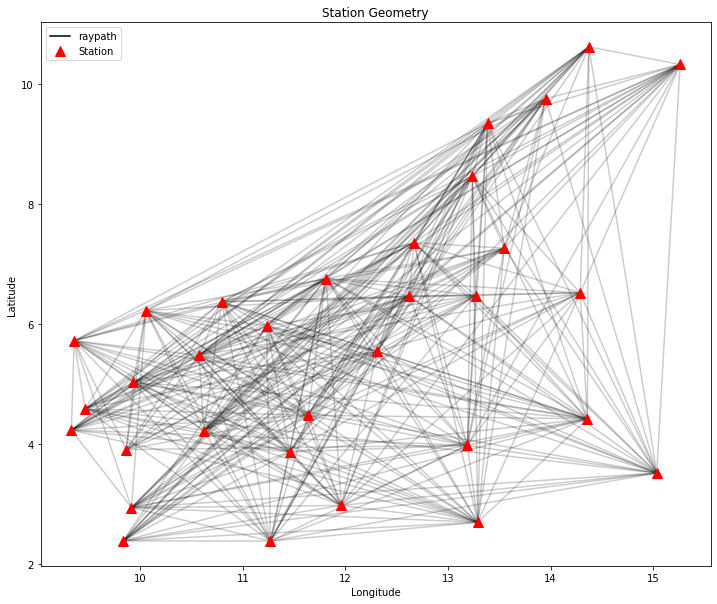

In [13]:
fig, ax = plt.subplots(figsize=(12, 10))
for path in paths:
    plt.plot(path.T[0], path.T[1], color="black", alpha=0.2)
for coord in coords:
    plt.plot(coord[0], coord[1], '^', color="red", markersize=10)

# Create custom legend
# --------------------------------------------------------------------------------------------------------------- #
my_legend = [Line2D([0], [0], color="black", label="raypath"),
             Line2D([0], [0], marker="^", color="red", label="Station", lw=0, markersize=10)]
# --------------------------------------------------------------------------------------------------------------- #

ax.legend(handles=my_legend)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Station Geometry")
plt.show()

## d = Gm

The basic premise of inversion is that the observed data is the matrix multiplacation of the weight matrix 'G', with the model matrix 'm'. Ideally we could calculate the inverse of the weigh matrix, such that $G^{-1}d = m$. However, reality may be more complicated. In many cases G may be singular, or too large to invert, so more sophisticated approaches are often required.

In this scheme, $G$ is an M x N matrix, where M is the number of raypaths, and N is the total number of nodes in the grid. The values of $G$ represent the integration of slowness (1 / velocity) through each grid node. For each raypath, the weights in $G$ will be non-zero for the nodes that the ray samples, while the weights in G will be zero if the raypath does not sample them. This tends to lead to a very sparse matrix.

In [14]:
# Modified from seismic-noise-tomgraphy

vels = disp_curves["group_velocity"]
s = (dists / vels).sum() / dists.sum()
v0 = 1.0 / s
G = rosesutils.make_G(paths, grid, v0)

In [15]:
# Modified from seismic-noise-tomgraphy

dobs = np.matrix(dists / vels - dists / v0).T
density = rosesutils.path_density(grid, paths, window=(lonstep, latstep)) # Calculate raypath density
path_density = grid.to_2D_array(density) # Reshape the density into an M x N matrix

This tomgraphy scheme requires the estimation of the covariance matrix of the errors in the observed data. In this case I simply estimate the values of this matrix to be 3 times the standard deviation of the observed velocities. This is probably not the best way of doing this, but it seems to work for this example.

In [16]:
# Modified from seismic-noise-tomgraphy

sigmav = np.ones((len(vels))) * 3 * np.std(vels) # Set sigma to be 3 time the standard deviation of velocities
sigmad = sigmav * dists / vels**2
Cinv = np.matrix(np.zeros((len(sigmav), len(sigmav))))
np.fill_diagonal(Cinv, 1.0 / sigmad**2)

In the below plot we can see that the raypath density is very similar to the raypath coverage. Note that the direction of raypaths is also important. If all the raypaths are crossing a grid node in the same direction, then there will be strong smearing in the direction of the ray.

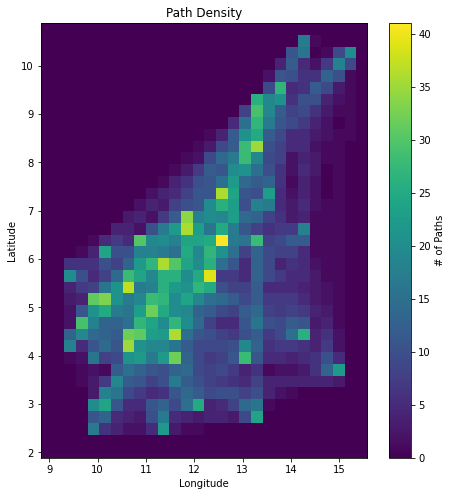

In [17]:
fig, ax = plt.subplots(figsize=(8,8))
extent = (grid.xmin, grid.get_xmax(), grid.ymin, grid.get_ymax())
im = ax.imshow(path_density.transpose(), extent=extent, origin="lower")
cbar = plt.colorbar(im)
cbar.set_label("# of Paths")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Path Density")
plt.show()

In this section the inversion parameters are setup, and the actual matrix algebra is performed. Some trial and error is often required to find the correct values for these parameters. Try playing around with each of the parameters to get an idea of how this affects the model.

In [18]:
# Modified from seismic-noise-tomgraphy

# Setup the inversion parameters
# --------------------------------------------------------------------------------------------------------------- #
correlation_length = 100 # correlation length a.k.a smoothing width
alpha = 15 # Smoothing parameter
beta = 1 # Strength of penalization term
lambda_ = 0.15 # Sharpness of raypath density weighting function
# --------------------------------------------------------------------------------------------------------------- #

dists_mat = np.zeros((grid.n_nodes(), grid.n_nodes()))
i_upper, j_upper = np.triu_indices_from(dists_mat)
lons_i, lats_i = grid.xy(i_upper)
lons_j, lats_j = grid.xy(j_upper)

dists_mat[i_upper, j_upper] = psutils.dist(lons1=lons_i, lats1=lats_i,
                                       lons2=lons_j, lats2=lats_j)
dists_mat += dists_mat.T

# Calculate the smoothing kernel
S = np.exp(- dists_mat**2 / (2 * correlation_length**2))
S /= S.sum(axis=-1) - np.diag(S)  # normalization of non-diagonal terms

# setting up spatial regularization matrix F
F = np.matrix(-S)
F[np.diag_indices_from(F)] = 1
F *= alpha

# Calculate regularization matrix Q
Q = F.T * F

for i, path_density in enumerate(density):
    Q[i, i] += beta ** 2 * np.exp(-2 * lambda_ * path_density)
    
covmopt = np.linalg.inv(G.T * Cinv * G + Q)
Ginv = covmopt * G.T # Compute the inverse matrix needed to invert
mopt = Ginv * Cinv * dobs # Compute the final estimated model
R = Ginv * Cinv * G # Compute the resolution matrix
v = grid.to_2D_array(v0 / (1 + mopt))

For convenience, I've included a wrapper function around all of the code we've previously seen. So, one can simply call `invert4model` with the appropriate parameters to perform the inversion.

In [19]:
disp_curves = pd.read_csv("data/cam/10.dat", index_col=None, header=None, delim_whitespace=True)
disp_curves.columns = ["source_name", "receiver_name", "group_velocity", "phase_velocity",
                       "signal2noise_ratio", "source_lon", "source_lat", "receiver_lon", "receiver_lat",
                       "inter-station_distance"]
print(len(disp_curves))
std_crit = (np.abs(disp_curves.group_velocity - np.mean(disp_curves.group_velocity))\
            < 3 * np.std(disp_curves.group_velocity))
disp_curves = disp_curves[std_crit]
print(len(disp_curves))

# Set up the inversion parameters
# ------------------------------ #
alpha = 15
beta = 1
correlation_length = 30
latstep = 0.25
lonstep = 0.25
# ------------------------------ #

# Do the inversion
# --------------------------------------------------------------------------------------------------------------- #
vels, paths, dists = make_paths(disp_curves)
grid = make_grid(disp_curves, tol, latstep, lonstep)
v, path_density, R, grid, Cinv, Ginv = invert4model(alpha, beta, lambda_, correlation_length, lonstep,
                                                    latstep, grid, vels, dists, paths)
# --------------------------------------------------------------------------------------------------------------- #

334
330


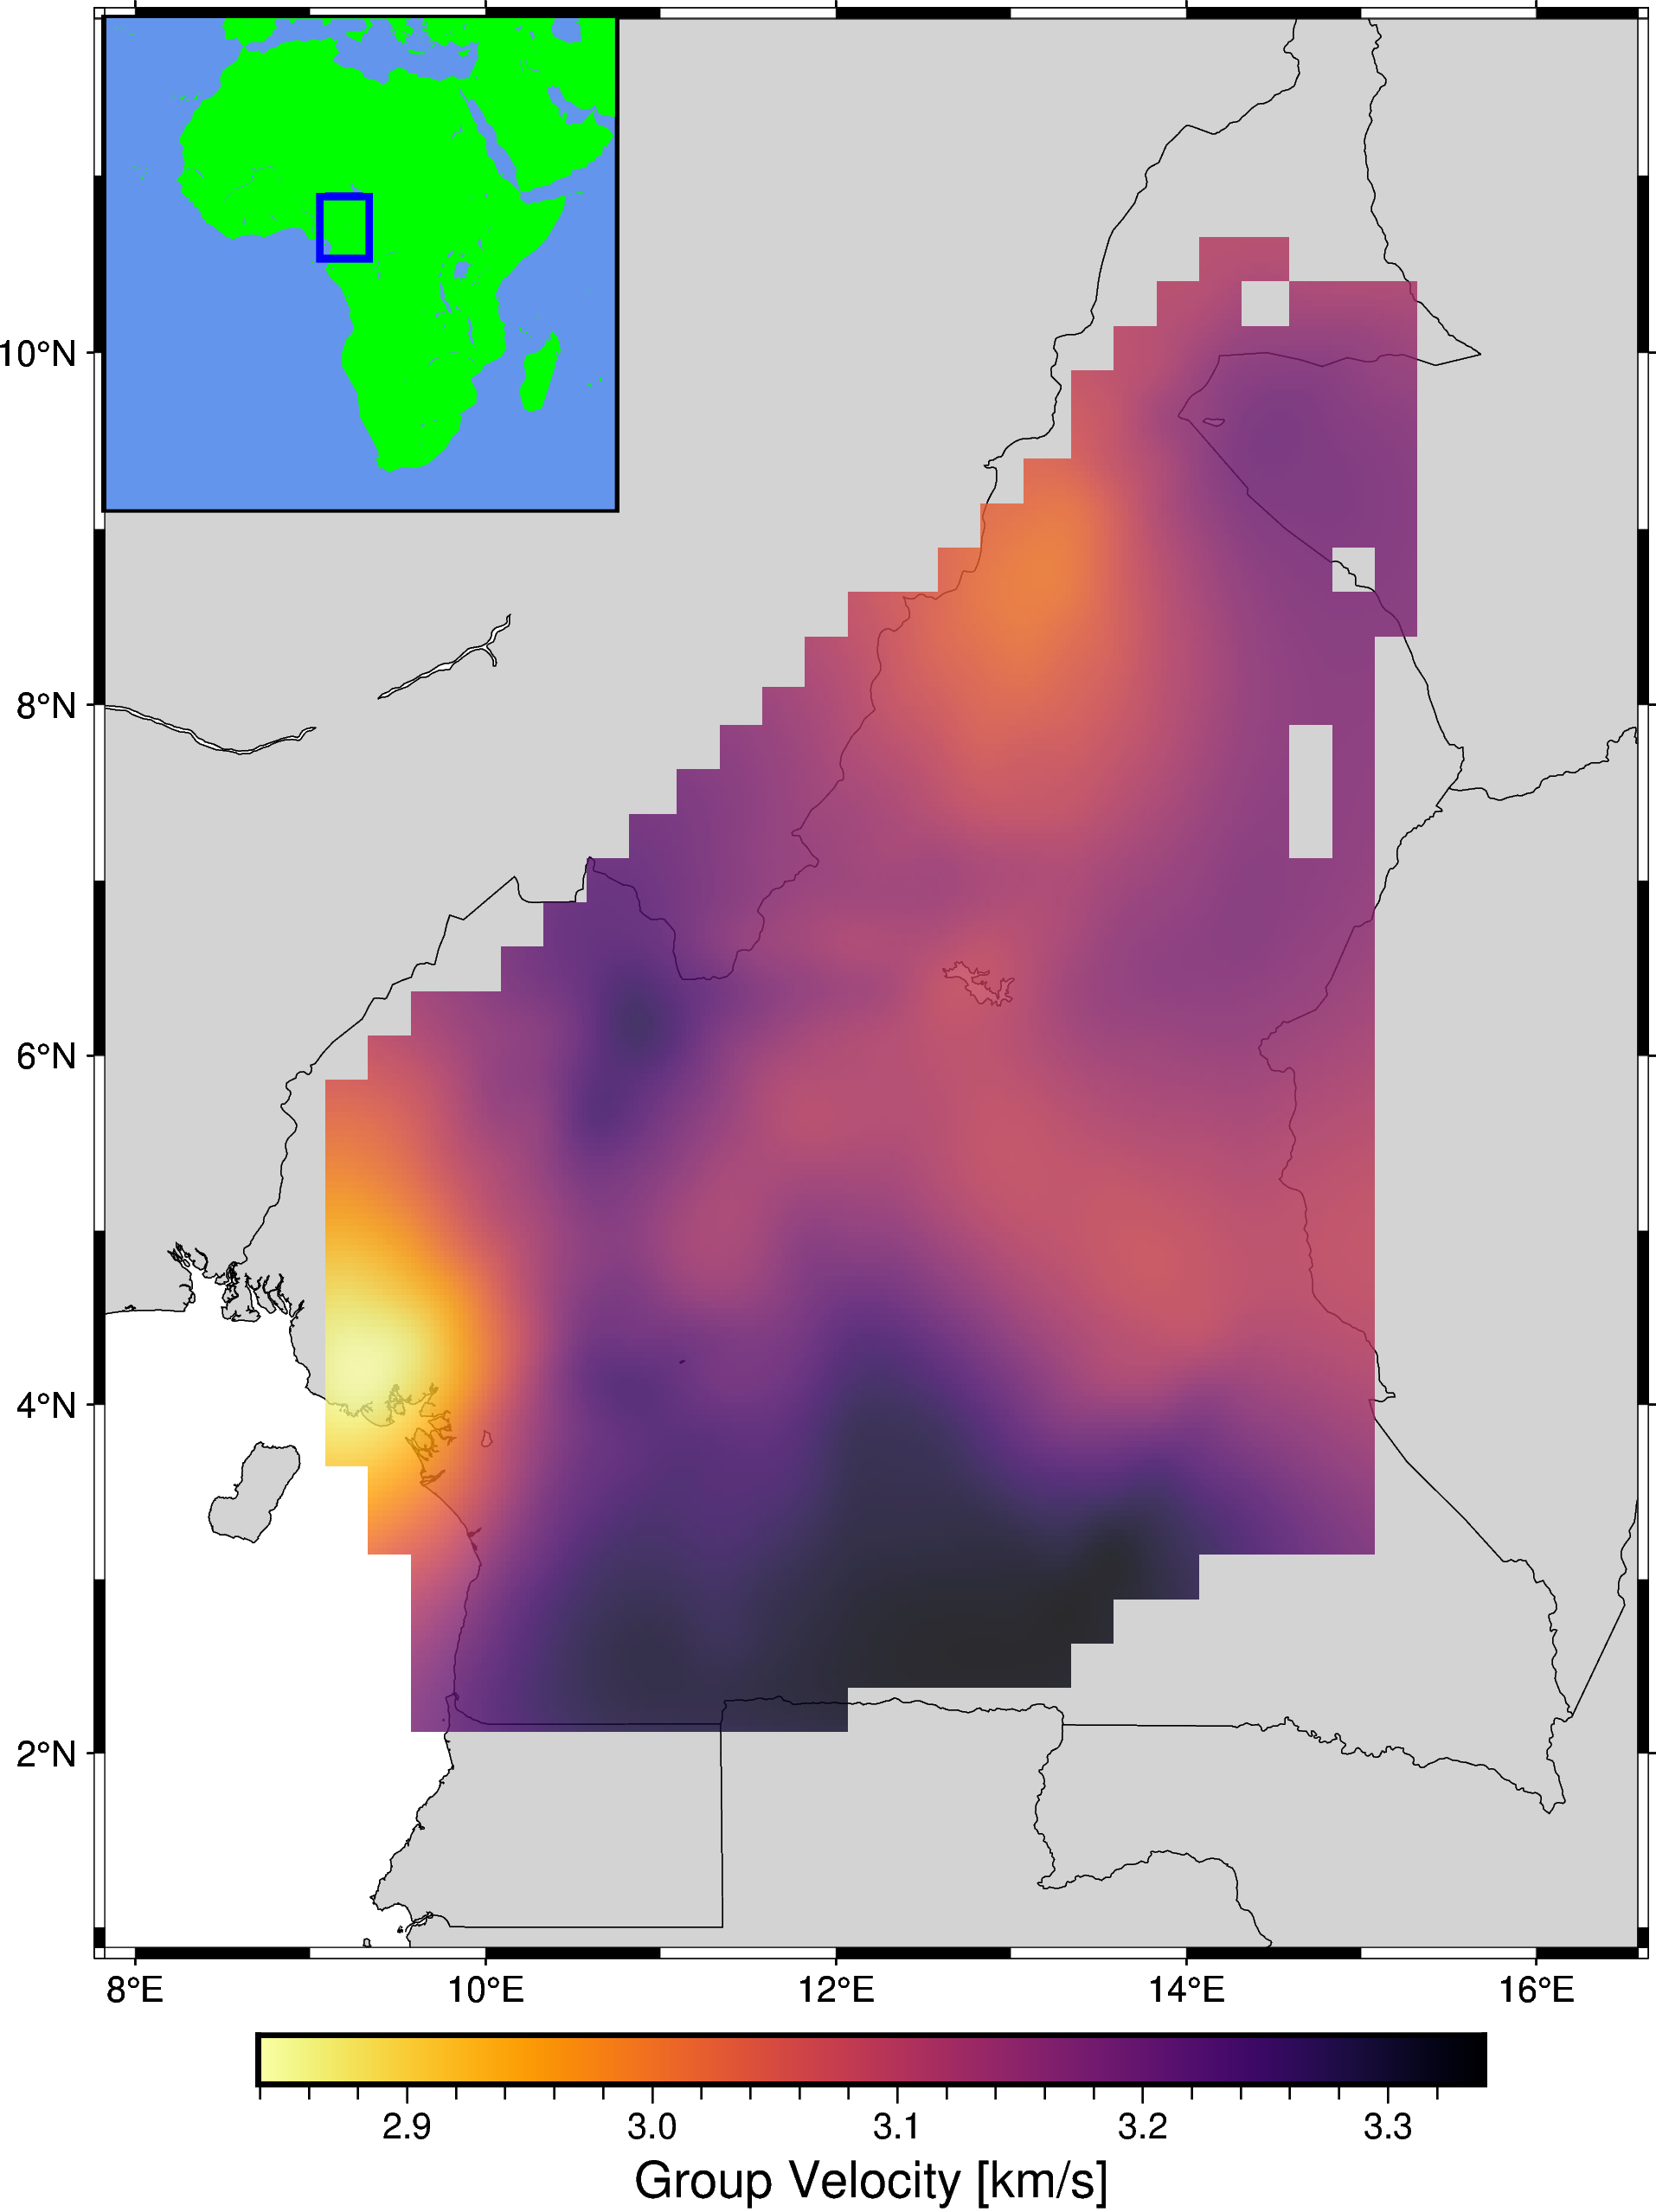

In [20]:
inset_region = [-30, 60, -40, 40]
fine_num_lats = 250
fine_num_lons = 250

plot_interpolated(grid, v, fine_num_lats, fine_num_lons, path_density, inset_region)

In order to test the resolution of our model, we will calculate some synthetic observations from a prescribed velocity model, and see if we can invert for the prescribed model.

In [21]:
# Modified from seismic-noise-tomography

alpha = 15
beta = 1
correlation_length = 30
latstep = 0.25
lonstep = 0.25

# Set up the inversion parameters
# ------------------------------ #
alpha = 15
beta = 1
correlation_length = 30
latstep = 0.25
lonstep = 0.25
# ------------------------------ #

# The purpose of doing the inversion here is simply to extract the Ginv and Cinv matrices, we will not use
# the actual data for the synthetic test
# --------------------------------------------------------------------------------------------------------------- #
vels, paths, dists = make_paths(disp_curves)
grid = make_grid(disp_curves, tol, latstep, lonstep)
v, path_density, R, grid, Cinv, Ginv = invert4model(alpha, beta, lambda_, correlation_length, lonstep,
                                                    latstep, grid, vels, dists, paths)
# --------------------------------------------------------------------------------------------------------------- #

vmid = v0
vmin = vmid - 0.5
vmax = vmid + 0.5
squaresize = 200

f_checkerboard = rosesutils.checkerboard_func(grid, vmid, vmin, vmax, squaresize)

dsynth = np.zeros_like(dobs)

for d, path, curve in zip(dsynth, paths, dists):
    lons, lats = path[:, 0], path[:, 1]
    
    ds = psutils.dist(lons1=lons[:-1], lats1=lats[:-1],
                      lons2=lons[1:], lats2=lats[1:])
    
    v = f_checkerboard(lons, lats)
    
    t = np.sum(ds * 0.5 * (1.0 / v[:-1] + 1.0 / v[1:]))
    
    d[...] = t - curve / vmid
    
msynth = Ginv * Cinv * dsynth
mest = grid.to_2D_array(vmid / (1 + msynth))

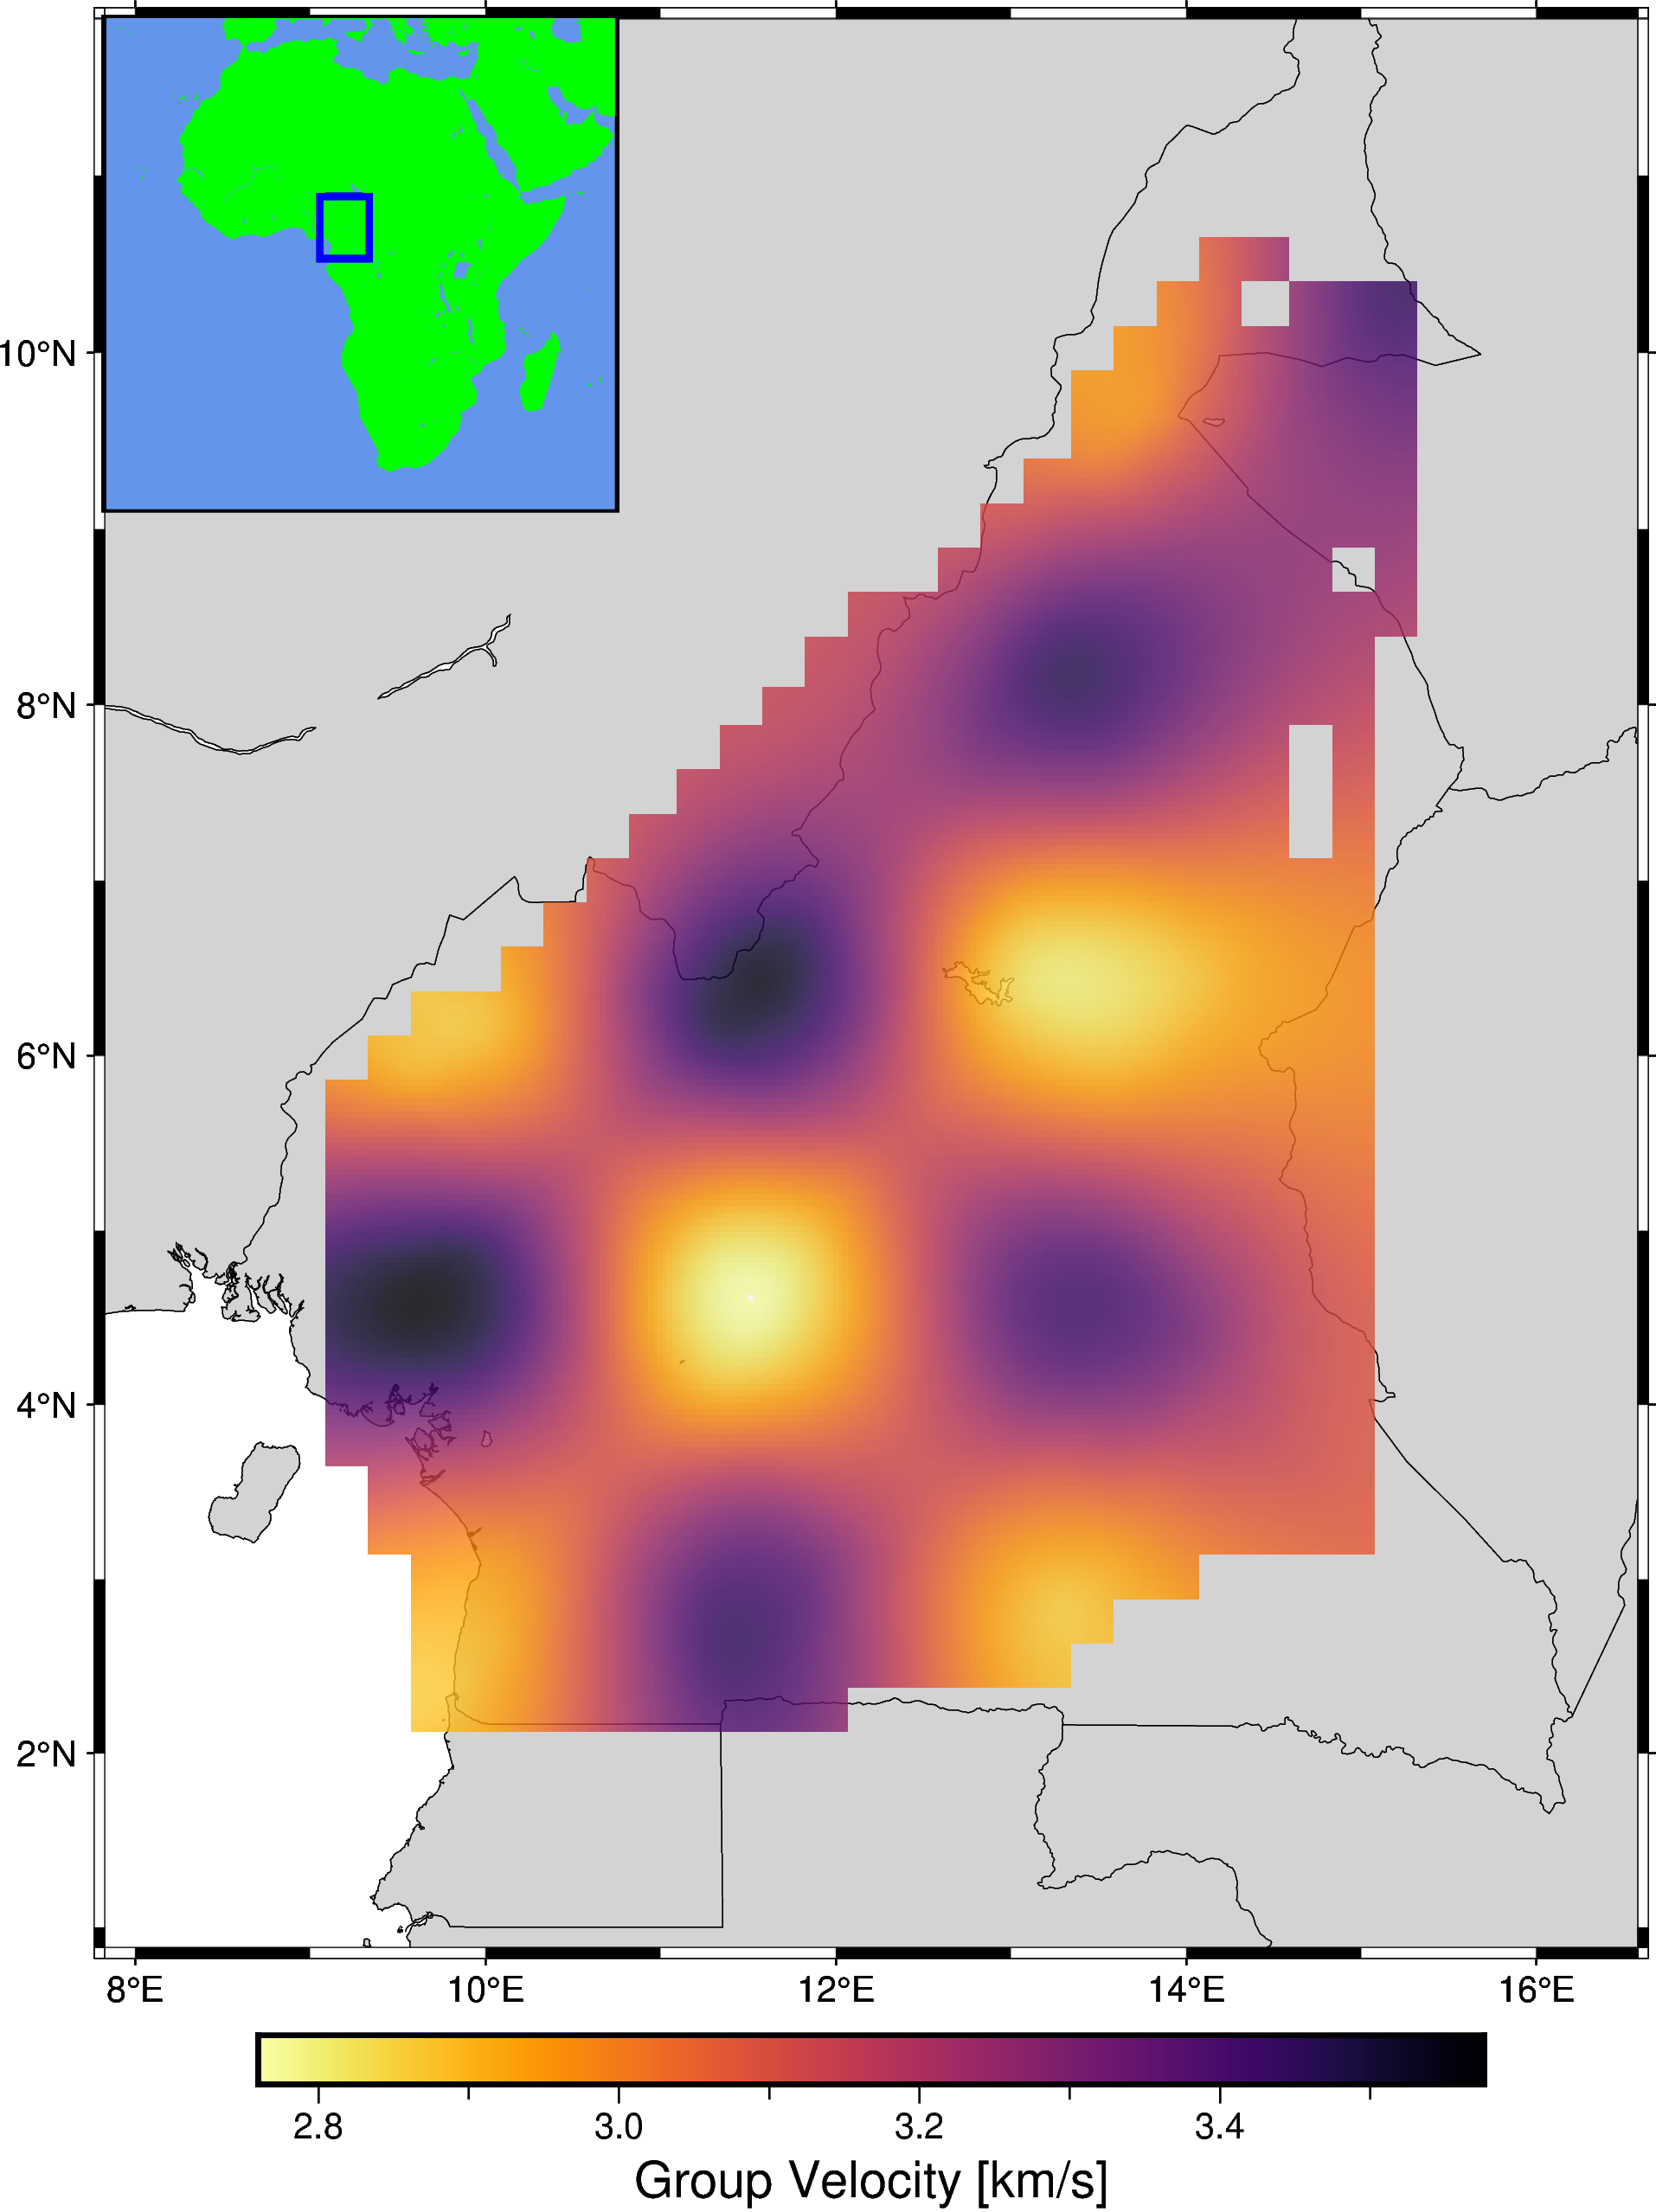

In [22]:
plot_interpolated(grid, mest, fine_num_lats, fine_num_lons, path_density, inset_region)

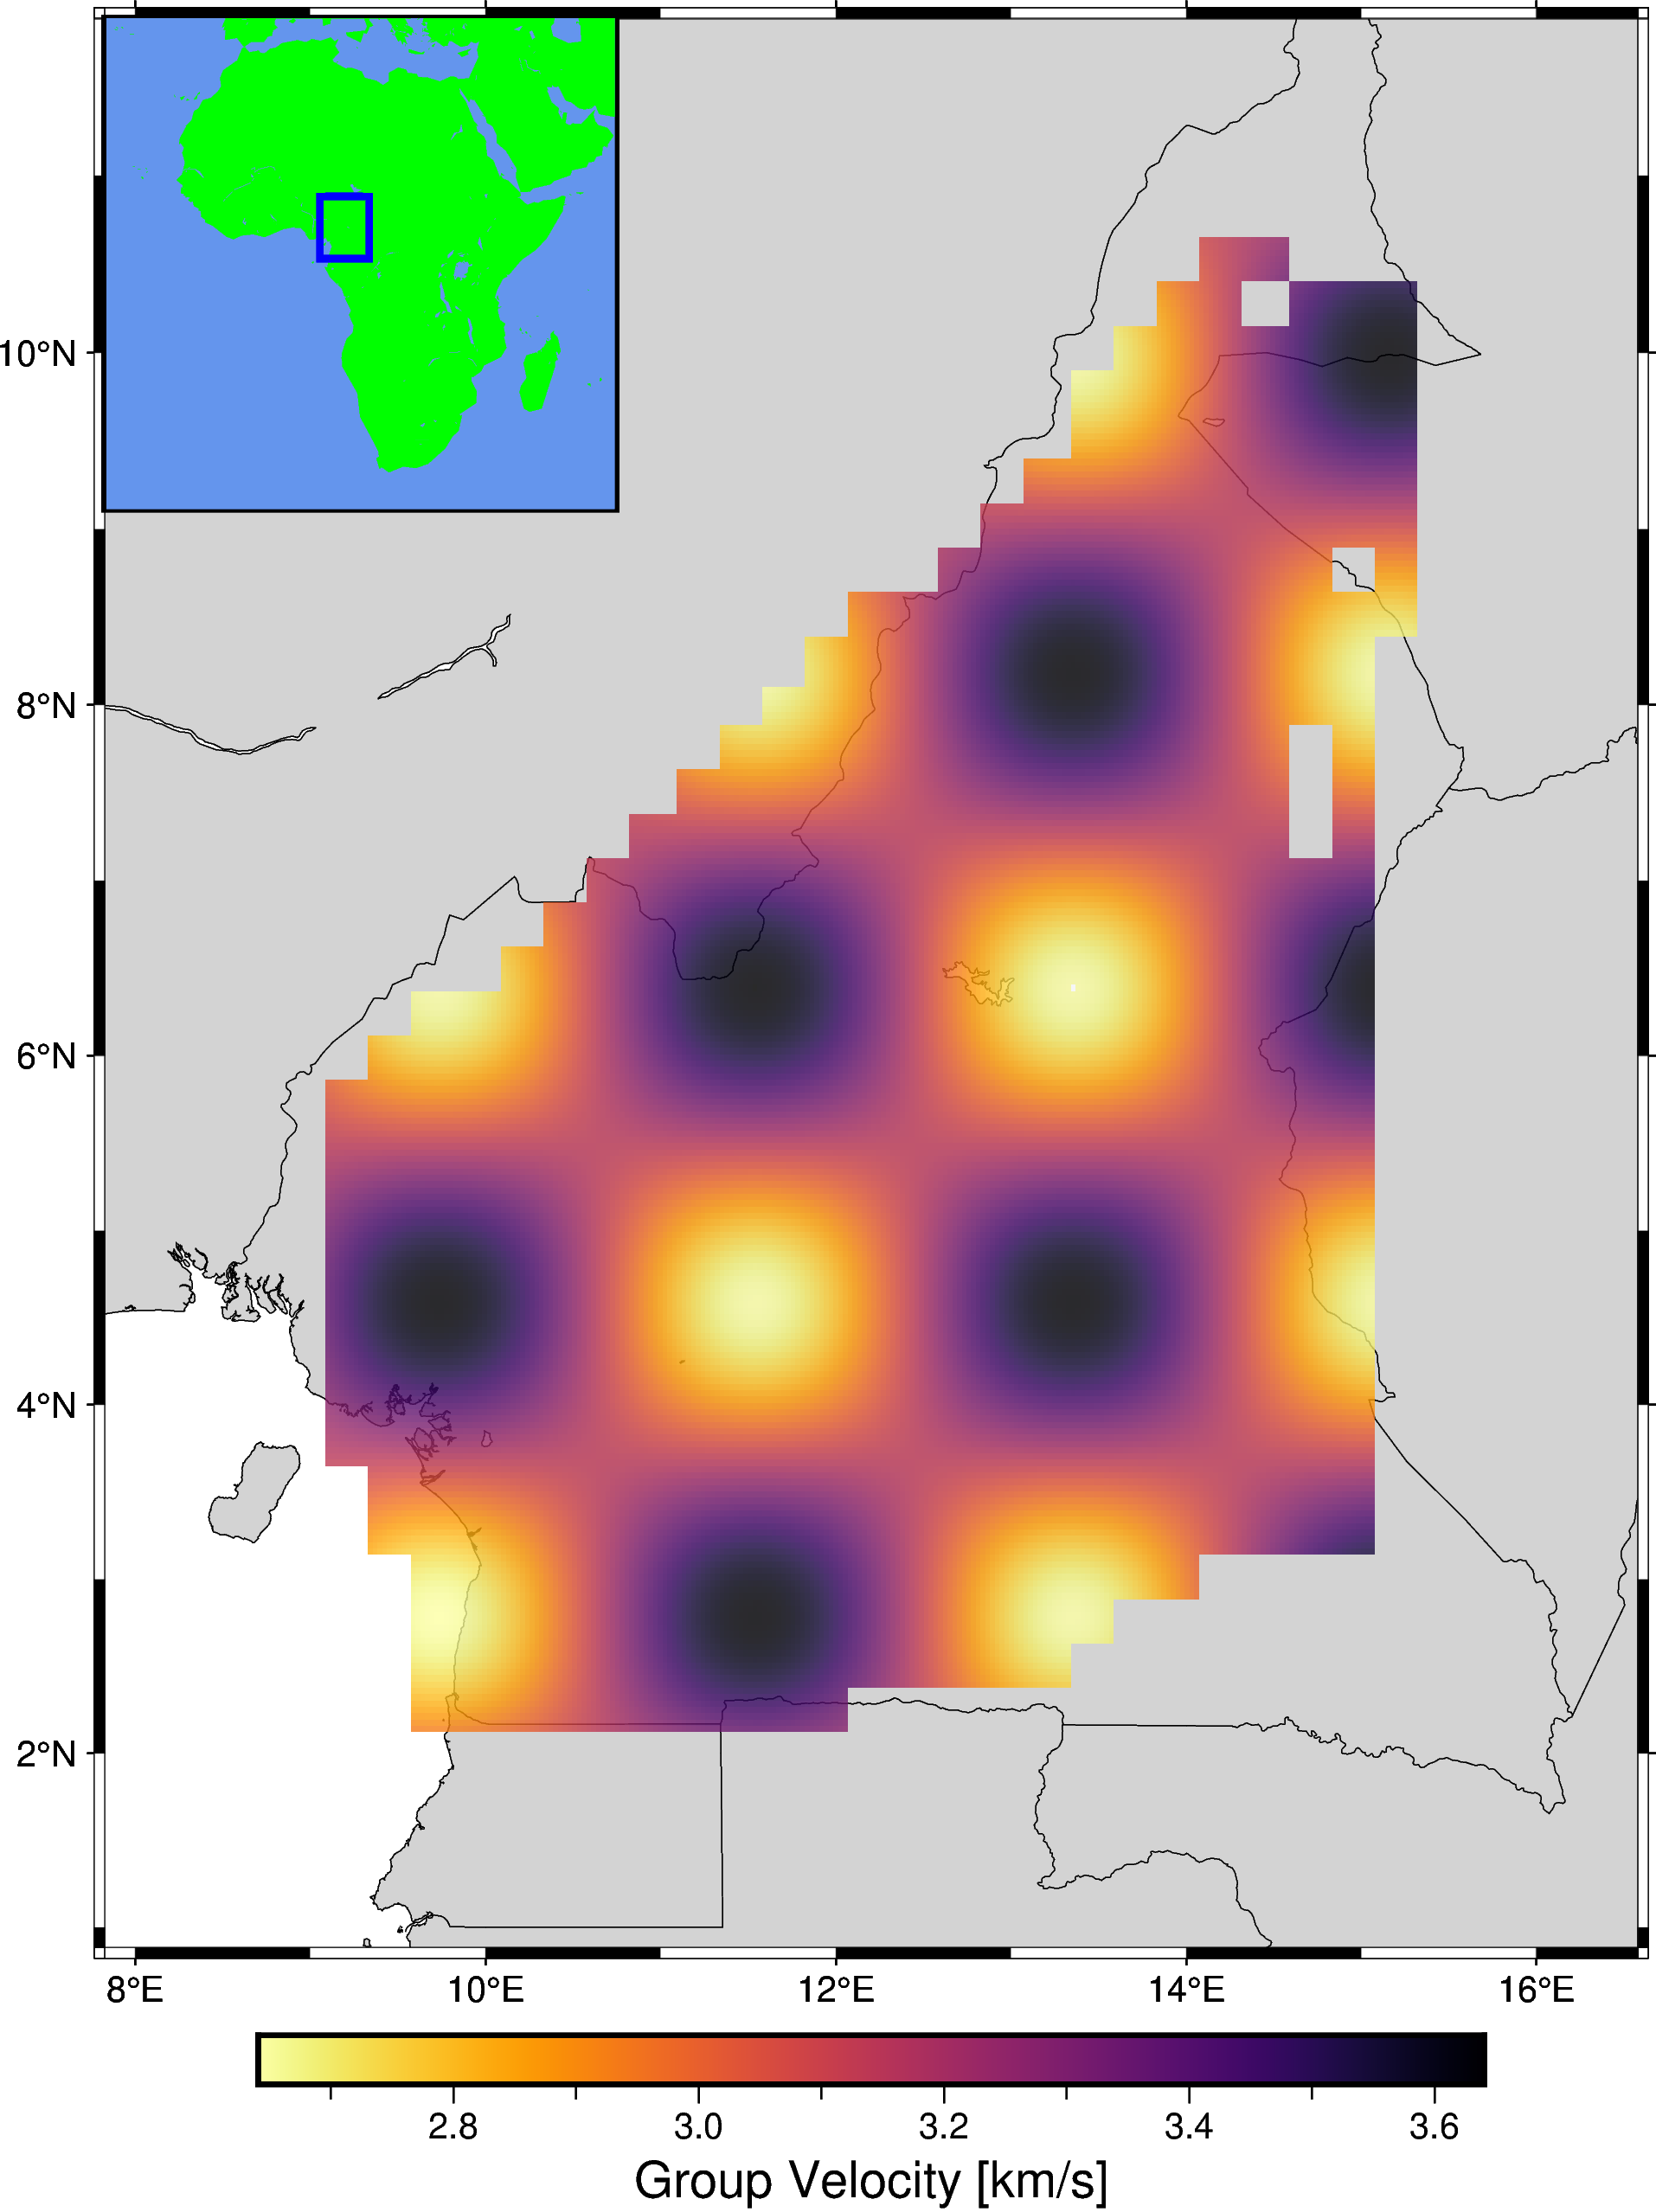

In [23]:
lons, lats = grid.xy_nodes()
a = grid.to_2D_array(f_checkerboard(lons, lats))
plot_interpolated(grid, a, fine_num_lats, fine_num_lons, path_density, inset_region)

There we go! We've created a 2-D map of surface wave velocities at one period. While a lot of shortcuts were taken to produce this image, we can still see some features that correspond to known geology. Notably, the effect of the Congo craton is observed as a high velocity anomaly in the south-east corner of the map. In order to make further inferences about the geology, it would be useful to create a 3-D shear wave velocity model. This is generally done by extracting the velocities at each period for one geographic location. The 1-D dispersion curve that results from this can then be inverted for the shear wave structure at that location. Doing this for each geographic location in the study grid produces a pseudo 3-D model, with a 1-D shear wave model at each grid node. I'll save this problem for another day. Here are some codes that may be used for this purpose.

Note that there is another dataset in the data directory. This dataset contains data for the Georgia Basin in British Columbia. Try making a 2-D period map from it with your new skills!

# References

- Barmin, M. P., Ritzwoller, M. H., & Levshin, A. L. (2001). A fast and reliable method for surface wave tomography. In Monitoring the comprehensive nuclear-test-ban treaty: Surface waves (pp. 1351-1375). _Birkhäuser, Basel_. https://doi.org/10.1007/PL00001225
- Goutorbe, B., de Oliveira Coelho, D. L., & Drouet, S. (2015). Rayleigh wave group velocities at periods of 6–23 s across Brazil from ambient noise tomography. _Geophysical Journal International_, 203(2), 869-882. https://doi.org/10.1093/gji/ggv343
- Jiang, C., & Denolle, M. A. (2020). NoisePy: A new high‐performance python tool for ambient‐noise seismology. _Seismological Research Letters_, 91(3), 1853-1866. https://doi.org/10.1785/0220190364
- Ojo, A. O., Ni, S., & Li, Z. (2017). Crustal radial anisotropy beneath Cameroon from ambient noise tomography. _Tectonophysics_, 696, 37-51. https://doi.org/10.1016/j.tecto.2016.12.018